In [1]:
import numpy as np 
import pandas as pd 

import os

In [2]:
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

#Libraries for NLP
import nltk

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

In [3]:
trainSetdf= pd.read_csv('/content/drive/MyDrive/information retrieval/train.csv')


In [4]:
trainSetdf.head(15)

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0
5,6,On maximizing the fundamental frequency of the...,Let $\Omega \subset \mathbb{R}^n$ be a bound...,0,0,1,0,0,0
6,7,On the rotation period and shape of the hyperb...,We observed the newly discovered hyperbolic ...,0,1,0,0,0,0
7,8,Adverse effects of polymer coating on heat tra...,The ability of metallic nanoparticles to sup...,0,1,0,0,0,0
8,9,SPH calculations of Mars-scale collisions: the...,We model large-scale ($\approx$2000km) impac...,0,1,0,0,0,0
9,10,$\mathcal{R}_{0}$ fails to predict the outbrea...,Time varying susceptibility of host at indiv...,0,0,0,0,1,0


In [5]:
#gathering abstracts from train data

train = trainSetdf["ABSTRACT"]

In [6]:
def gatherTopnWords(topNwords, count_vectorizer, textData):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorizedHeadlines = count_vectorizer.fit_transform(textData.values)
    vectorizedTotal = np.sum(vectorizedHeadlines, axis=0)
    wordIndices = np.flip(np.argsort(vectorizedTotal)[0,:], 1)
    wordValues = np.flip(np.sort(vectorizedTotal)[0,:],1)
    wordVectors = np.zeros((topNwords, vectorizedHeadlines.shape[1]))

    for i in range(topNwords):
          wordVectors[i,wordIndices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
              word in count_vectorizer.inverse_transform(wordVectors)]
    
    return (words, wordValues[0,:topNwords].tolist()[0])


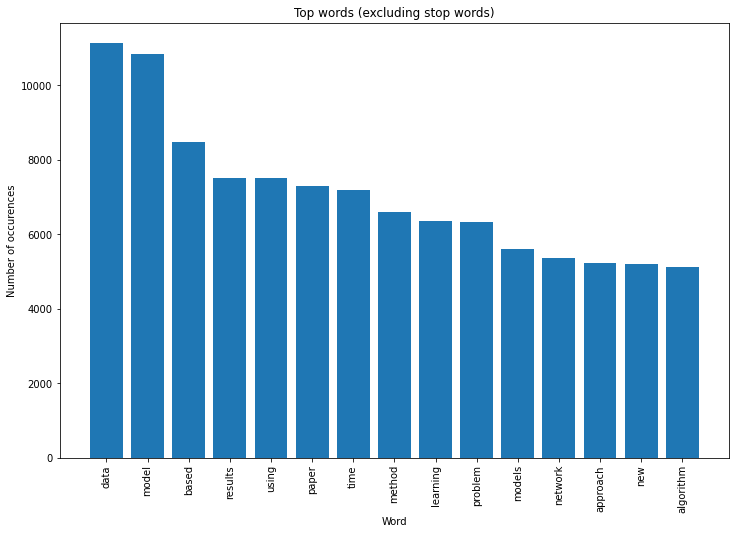

range(0, 15)


In [7]:
#Removing stop words and developing a list of top words in abstracts
cv = CountVectorizer(stop_words='english')
words, word_val = gatherTopnWords(topNwords=15, count_vectorizer=cv, textData=train)
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(words, word_val)
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()
print(range(len(words)))

In [8]:
#Topic Modelling
#Preprocessing for LDA

#Making a class for both tokenization and lemmatization
lemm = nltk.WordNetLemmatizer()
class LemmaCountVectorizer(CountVectorizer):
    def bAnalyzer(self):
        analyzer = super(LemmaCountVectorizer, self).bAnalyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))

In [9]:
# Storing all training text in a list
text = list(train)

# Calling the overwritten count vectorizer
tf_vectorizer = LemmaCountVectorizer(max_df=0.95, min_df=2, stop_words='english', 
                                     decode_error='ignore')
tf = tf_vectorizer.fit_transform(text)

In [10]:
#LDA (Sklearn)
#number of topics
numberOfTopics=10

In [11]:
#Creating an LDA instance
lda = LatentDirichletAllocation(n_components=numberOfTopics, max_iter=5, learning_method='online', 
                                learning_offset=50., random_state=0, verbose =0)
lda.fit(tf)

#Making an LDA topic matrix of the corpus
ldaTopicMatrix = lda.fit_transform(tf)

In [12]:
# Define helper functions
def gatherKeys(topicMatrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topicMatrix.argmax(axis=1).tolist()
    return keys

def countingKeys(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [13]:
# Getting the categories and counts from the lda model
ldaKeys = gatherKeys(ldaTopicMatrix)
ldaCategories, ldaCounts = countingKeys(ldaKeys)

In [14]:
# Function to get top words from each category
def getTopnWords(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of numberOfTopics strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    topWordIndices = []
    for topic in range(numberOfTopics):
        tempVectorSum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                tempVectorSum += document_term_matrix[i]
        tempVectorSum = tempVectorSum.toarray()
        topNWordIndices = np.flip(np.argsort(tempVectorSum)[0][-n:],0)
        topWordIndices.append(topNWordIndices)   
    topEords = []
    for topic in topWordIndices:
        topicWords = []
        for index in topic:
            tempWordVector = np.zeros((1,document_term_matrix.shape[1]))
            tempWordVector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(tempWordVector)[0][0]
            topicWords.append(the_word.encode('ascii').decode('utf-8'))
        topicWords.append(" ".join(topicWords))         
    return topicWords

In [15]:
# Printing words from each topic
topNwords = getTopnWords(9, ldaKeys, tf, tf_vectorizer)

for i in range(len(topNwords)):
    print("Topic {}:\n ".format(i), topNwords[i] + "\n")

Topic 0:
  mathbb

Topic 1:
  mathcal

Topic 2:
  frac

Topic 3:
  let

Topic 4:
  prove

Topic 5:
  left

Topic 6:
  right

Topic 7:
  omega

Topic 8:
  alpha

Topic 9:
  mathbb mathcal frac let prove left right omega alpha



In [16]:
#Transforming the LDA topic matrix to 2 dimensions for plotting
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(ldaTopicMatrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 20972 samples in 0.039s...
[t-SNE] Computed neighbors for 20972 samples in 2.174s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20972
[t-SNE] Computed conditional probabilities for sample 2000 / 20972
[t-SNE] Computed conditional probabilities for sample 3000 / 20972
[t-SNE] Computed conditional probabilities for sample 4000 / 20972
[t-SNE] Computed conditional probabilities for sample 5000 / 20972
[t-SNE] Computed conditional probabilities for sample 6000 / 20972
[t-SNE] Computed conditional probabilities for sample 7000 / 20972
[t-SNE] Computed conditional probabilities for sample 8000 / 20972
[t-SNE] Computed conditional probabilities for sample 9000 / 20972
[t-SNE] Computed conditional probabilities for sample 10000 / 20972
[t-SNE] Computed conditional probabilities for sample 11000 / 20972
[t-SNE] Computed conditional probabilities for sample 12000 / 20972
[t-SNE] Computed conditional probabilities for sa

In [17]:
# Define helper functions
#def gatherMeanTopicVectors(keys, two_dim_vectors):
 #   '''
  #  returns a list of centroid vectors from each predicted topic category
   # '''
    #averageTopicVectors = []
    #for t in range(numberOfTopics):
     #   articlesInTopics = []
      #  for i in range(len(keys)):
       #     if keys[i] == t:
        #        articlesInTopics.append(two_dim_vectors[i])    
        
        #articlesInTopics = np.vstack(articlesInTopics)
        #averageArticlesInTopics = np.mean(articlesInTopics, axis=0)
        #averageTopicVectors.append(averageArticlesInTopics)
    #return averageTopicVectors

In [18]:
documentTopic = lda.transform(tf)

for n in range(10):
    topicMostPr = documentTopic[n].argmax()
    print("Document #{} - topic: {}\n".format(n,topicMostPr))

Document #0 - topic: 1

Document #1 - topic: 1

Document #2 - topic: 8

Document #3 - topic: 8

Document #4 - topic: 1

Document #5 - topic: 8

Document #6 - topic: 5

Document #7 - topic: 0

Document #8 - topic: 7

Document #9 - topic: 8



In [19]:
#Advanced Analysis of LDA
#My main goal is to

#1.Find the most relevant articles for each topic so they can be used as the links for further research
#2.maybe find another way to list the most relevant articles such as using rating or views (later)


In [20]:
# making a dataframe from the document-topic matrix
documentTopic_df = pd.DataFrame(data=documentTopic)
documentTopic_df

,0,1,2,3,4,5,6,7,8,9
0,0.026312,0.829276,0.000559,0.000559,0.000559,0.000559,0.000559,0.140500,0.000559,0.000559
1,0.002223,0.656920,0.002223,0.002222,0.002222,0.002223,0.002223,0.097756,0.229766,0.002222
2,0.001923,0.066826,0.001923,0.001923,0.001923,0.078167,0.001923,0.001923,0.841545,0.001924
3,0.121582,0.001588,0.001587,0.017465,0.001587,0.001587,0.125995,0.001588,0.688308,0.038713
4,0.035588,0.891755,0.001235,0.001235,0.001235,0.034870,0.001235,0.030378,0.001235,0.001235
...,...,...,...,...,...,...,...,...,...,...
20967,0.000855,0.701515,0.123890,0.018217,0.000855,0.000855,0.000855,0.127726,0.000855,0.024377
20968,0.701670,0.001220,0.141792,0.001220,0.001220,0.051966,0.001220,0.097254,0.001220,0.001220
20969,0.000935,0.678901,0.052701,0.000935,0.000935,0.000935,0.232152,0.000935,0.030637,0.000935
20970,0.000870,0.687771,0.000870,0.000870,0.009908,0.032538,0.020483,0.052867,0.078790,0.115033


In [21]:
# printing the top 'n' articles for each topic
for (columnName, columnData) in documentTopic_df.iteritems():
    n = 3
    print('Topic #', columnName)
    sortedTopic = pd.DataFrame(data=columnData.values).sort_values(by=0, ascending=False)
    sortedTopic.columns = [columnName]
    print(sortedTopic[:n])
    
    # store IDs and titles of top articles in a dataframe
    ids = sortedTopic[:n].index

Topic # 0
             0
12    0.989998
4327  0.986956
3878  0.986764
Topic # 1
             1
3632  0.994193
5488  0.994116
5639  0.994078
Topic # 2
             2
4109  0.926732
3455  0.926431
2630  0.904486
Topic # 3
             3
1727  0.534131
5271  0.446373
9402  0.422292
Topic # 4
             4
991   0.481067
3745  0.432334
2168  0.427761
Topic # 5
              5
4185   0.989411
12460  0.962927
1356   0.962351
Topic # 6
             6
7428  0.884910
44    0.706300
8097  0.694842
Topic # 7
             7
5332  0.937455
705   0.925720
4807  0.917062
Topic # 8
             8
4642  0.993661
9231  0.992034
1573  0.991508
Topic # 9
              9
5603   0.983926
18614  0.955772
4389   0.925409


1    7580
8    5769
0    2234
7    1818
2    1740
5    1010
9     546
6     229
4      31
3      15
dtype: int64

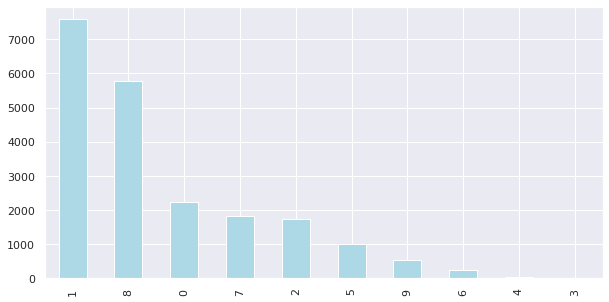

In [22]:
#plotting the distribution of documents over each topic
sns.set(rc={'figure.figsize':(10,5)})
documentTopic_df.idxmax(axis=1).value_counts().plot.bar(color='lightblue')

#store the distributions in a dataframe
distribution = documentTopic_df.idxmax(axis=1).value_counts()
distribution